In [65]:
import pandas as pd
import numpy as np
import json
import seaborn as sns

import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from tools import *

# Defining MLP Architecture

In [66]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers):
        super(MLP, self).__init__()
        
        # Create a list to hold the layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())  # Add activation after first hidden layer
        
        # Add hidden layers
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.ReLU())  # Add activation after hidden layers
        
        # Add the output layer
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
        
        # Use nn.Sequential to combine layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [67]:

# Load your data
merged_dataset = pd.read_csv('datasets/merged_dataset.csv', low_memory=False)  # Assuming your data is in a CSV file

In [68]:
nb_ATAC_seq_rows = 8
ATAC_seq_names = merged_dataset.columns[:nb_ATAC_seq_rows]
all_names = ""
for name in ATAC_seq_names:
    all_names += f' {name}'
print(all_names)

 peakStart peakEnd peakName peakScore FGRstart FGRend FGRstrand region


In [69]:
# Regions of interest

reg_interest = ['promoter', 'enhancer', 'geneBody']
reg_ix_interest = []
min_common_occ_nb = 1000000
for region in reg_interest:
    occ_reg = (merged_dataset['region']==region_dict[region]).sum()
    if occ_reg < min_common_occ_nb:
        min_common_occ_nb = occ_reg
    print((merged_dataset['region']==region_dict[region]).sum())



10812
9896
47942


In [70]:
def train_MLP(mlp_dataset, min_common_occ_nb, roi_list,  nb_runs, list_l_rate, nb_hidden_layers, list_nb_hn_1, list_nb_hn_2, summary):
    
    compendium_rows = nb_runs*len(list_l_rate)*len(list_nb_hn_1)*len(list_nb_hn_2)
    compendium = array_zeros = np.zeros((compendium_rows, 2+nb_hidden_layers+1)) # 3 as in: run, l_rate | 1 as in: performance

    compendium_idx = 0
    best_mlp_score = 0
    best_loss = 10


    # Define the number of samples for each region
    N = int(min_common_occ_nb*0.8)  # Adjust this value as needed

    # Select N random rows for each region
    sample_list = []
    for roi in roi_list:
        sample_list.append(mlp_dataset[mlp_dataset['region'] == region_dict[roi]].sample(n=N, random_state=42))

    # Concatenate the sampled rows to create the final dataset
    balanced_dataset = pd.concat(sample_list, ignore_index=True)

    X = balanced_dataset.drop(['peakStart', 'peakEnd', 'peakName', 'peakScore', 'FGRstart', 'FGRend', 'FGRstrand', 'region'], axis=1).values  # Features
    y = balanced_dataset['region'].values  # Target variable


    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    input_size = X_train.shape[1]

    for run_idx in range(nb_runs):
        for l_rate in list_l_rate:
            for nb_hn_1 in list_nb_hn_1:
                for nb_hn_2 in list_nb_hn_2:
                    list_nb_hn = [nb_hn_1, nb_hn_2]


                    # Instantiate the model
                    model = MLP(input_size, len(roi_list), list_nb_hn)  # Use the dynamic MLP model

                    # Define the loss function and optimizer
                    criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
                    optimizer = optim.Adam(model.parameters(), lr=l_rate*0.001)  # Adam optimizer

                    # Train the model
                    num_epochs = 500
                    
                    loss_vs_epoch = []
                    for epoch in range(num_epochs):
                        model.train()
                        optimizer.zero_grad()  # Clear the gradients
                        outputs = model(X_train_tensor)  # Forward pass
                        loss = criterion(outputs, y_train_tensor)  # Compute loss
                        loss.backward()  # Backward pass
                        optimizer.step()  # Update weights

                        if (epoch + 1) % 500 == 0:  # Print loss every 10 epochs
                            print(f'Run {compendium_idx+1}/{compendium.shape[0]} : Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
                        loss_vs_epoch.append(loss.item())


                    # Evaluate the model
                    model.eval()
                    with torch.no_grad():
                        y_pred = model(X_test_tensor)  # Forward pass
                        _, predicted_classes = torch.max(y_pred, 1)  # Get predicted class labels

                    # Print evaluation metrics
                    report_dict = classification_report(y_test, predicted_classes.numpy(), target_names=roi_list, output_dict=True, zero_division=0)

                    # Store the precision values in a variable
                    precisions = {key: value['precision'] for key, value in report_dict.items() if key != 'accuracy'}
                    recalls = {key: value['recall'] for key, value in report_dict.items() if key != 'accuracy'}
                    f1_scores = {key: value['f1-score'] for key, value in report_dict.items() if key != 'accuracy'}
                    supports = {key: value['support'] for key, value in report_dict.items() if key != 'accuracy'}

                    mlp_score = 0
                    for roi in roi_list:
                        mlp_score += f1_scores[roi]
                    mlp_score = mlp_score/len(roi_list)


                    if mlp_score > best_mlp_score:
                    # if loss.item() < best_loss:
                        best_y_test = y_test
                        best_predicted_classes = predicted_classes
                        best_loss_vs_epoch = loss_vs_epoch
                        best_mlp_score = mlp_score
                        best_loss = loss.item()


                    compendium[compendium_idx] = [run_idx, l_rate, nb_hn_1, nb_hn_2, mlp_score] 
                    compendium_idx += 1
        
    if summary:
        print(classification_report(y_test, predicted_classes.numpy(), target_names=reg_interest, zero_division=0))
        plot_results(nb_hidden_layers, reg_interest, best_y_test, best_predicted_classes, best_loss_vs_epoch, compendium, l_rate)
        
    return compendium

# Grid Search for 2 Hidden Layers

In [71]:

nb_runs = 10
nb_hidden_layers =2
list_l_rate  = [5,10,15,20] #[10,20]
list_nb_hn_1 = [4,8,12,16,20,24,32] #[4,8,12,16]
list_nb_hn_2 = [4,8,12,16,20,24,32] #[4,8,12,16]
summary = False

compendium = train_MLP(merged_dataset, min_common_occ_nb, reg_interest,  nb_runs, list_l_rate, nb_hidden_layers, list_nb_hn_1, list_nb_hn_2, summary)





Run 1/1960 : Epoch [500/500], Loss: 0.7815
Run 2/1960 : Epoch [500/500], Loss: 0.7778
Run 3/1960 : Epoch [500/500], Loss: 0.7725
Run 4/1960 : Epoch [500/500], Loss: 0.7590
Run 5/1960 : Epoch [500/500], Loss: 0.7650
Run 6/1960 : Epoch [500/500], Loss: 0.7611
Run 7/1960 : Epoch [500/500], Loss: 0.7632
Run 8/1960 : Epoch [500/500], Loss: 0.7396
Run 9/1960 : Epoch [500/500], Loss: 0.7401
Run 10/1960 : Epoch [500/500], Loss: 0.7323
Run 11/1960 : Epoch [500/500], Loss: 0.7334
Run 12/1960 : Epoch [500/500], Loss: 0.7312
Run 13/1960 : Epoch [500/500], Loss: 0.7280
Run 14/1960 : Epoch [500/500], Loss: 0.7241
Run 15/1960 : Epoch [500/500], Loss: 0.7266
Run 16/1960 : Epoch [500/500], Loss: 0.7152
Run 17/1960 : Epoch [500/500], Loss: 0.7126
Run 18/1960 : Epoch [500/500], Loss: 0.7092
Run 19/1960 : Epoch [500/500], Loss: 0.7092
Run 20/1960 : Epoch [500/500], Loss: 0.7055
Run 21/1960 : Epoch [500/500], Loss: 0.6950
Run 22/1960 : Epoch [500/500], Loss: 0.6973
Run 23/1960 : Epoch [500/500], Loss: 0.69

In [72]:
df = pd.DataFrame(compendium, columns=['run_idx', 'l_rate', 'nb_hn_1', 'nb_hn_2', 'mlp_score'])

# Group by the unique combinations of 'l_rate', 'nb_hn_1', and 'nb_hn_2'
grouped_df = df.groupby(['l_rate', 'nb_hn_1', 'nb_hn_2']).agg(
    mean_mlp_score=('mlp_score', 'mean'),
    std_mlp_score=('mlp_score', 'std')
).reset_index()

# Find the combination with the highest mean score
best_combination = grouped_df.loc[grouped_df['mean_mlp_score'].idxmax()]

print("Best combination:")
print(best_combination)

Best combination:
l_rate             5.000000
nb_hn_1            8.000000
nb_hn_2           32.000000
mean_mlp_score     0.653299
std_mlp_score      0.002480
Name: 13, dtype: float64


In [73]:
best_combination[0]

/tmp/ipykernel_247866/3797287149.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_combination[0]


5.0

/tmp/ipykernel_247866/2679654814.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_l_rate  = [int(best_combination[0])]
/tmp/ipykernel_247866/2679654814.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_nb_hn_1 = [int(best_combination[1])]
/tmp/ipykernel_247866/2679654814.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list_nb_hn_2 = [int(best_combination[2])]


Run 1/4 : Epoch [500/500], Loss: 0.7260
Run 2/4 : Epoch [500/500], Loss: 0.7249
Run 3/4 : Epoch [500/500], Loss: 0.7276
Run 4/4 : Epoch [500/500], Loss: 0.7275
              precision    recall  f1-score   support

    promoter       0.76      0.72      0.74      2330
    enhancer       0.58      0.54      0.56      2435
    geneBody       0.62      0.70      0.66      2360

    accuracy                           0.65      7125
   macro avg       0.65      0.65      0.65      7125
weighted avg       0.65      0.65      0.65      7125



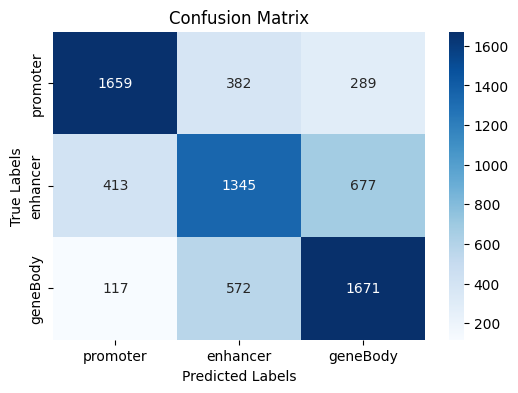

Best Combination:
nb_hn_l0: 8
nb_hn_l1: 32
Mean(Acc): 0.654
Stdev(Acc): 0.002


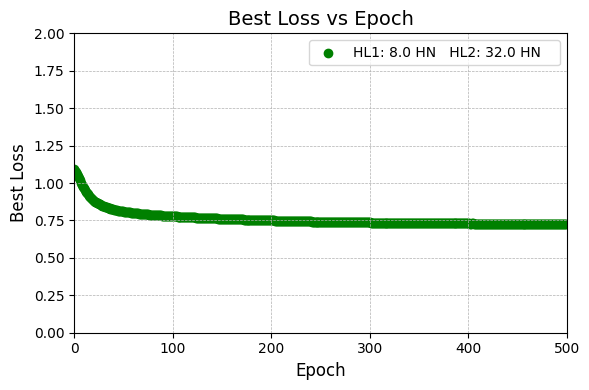

array([[ 0.        ,  5.        ,  8.        , 32.        ,  0.65708811],
       [ 1.        ,  5.        ,  8.        , 32.        ,  0.65594602],
       [ 2.        ,  5.        ,  8.        , 32.        ,  0.65109976],
       [ 3.        ,  5.        ,  8.        , 32.        ,  0.65280941]])

In [74]:

nb_runs = 4
nb_hidden_layers = 2
list_l_rate  = [int(best_combination[0])] 
list_nb_hn_1 = [int(best_combination[1])] 
list_nb_hn_2 = [int(best_combination[2])] 
summary = True
train_MLP(merged_dataset, min_common_occ_nb, reg_interest,  nb_runs, list_l_rate, nb_hidden_layers, list_nb_hn_1, list_nb_hn_2, summary)



In [75]:
print(f'{int(0.34*100*y.shape[0]/merged_dataset.shape[0])}')



9
